<a href="https://colab.research.google.com/github/marcellinus-witarsah/titanic-survival-model/blob/main/titanic-survival-model-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Model

![titanic_image](https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg)


This Project is aimed to create a model which can predict if a passenger survived a Titanic accident based on their data which consist of:
1.  PassengerId  (int64)  
2.  Survived     (int64)  
3.  Pclass       (int64)
4.  Name         (object)
5.  Sex          (object)
6.  Age          (float64)
7.  SibSp        (int64) 
8.  Parch        (int64)
9.  Ticket       (object) 
10. Fare         (float64)
11. Cabin        (object) 
12. Embarked     (object)

The outline of this project will consists of:
1. Data Preparation
2. Exploratory Data Analysis
3. Data Preprocessing and Feature Engineering
4. Modelling
5. Evaluation
6. Submission to Kaggle.

This project is based on competition being held on Kaggle which can be access using this link https://www.kaggle.com/c/titanic.





# Data Preparation
The data it self can be downloaded from Kaggle using which can be accessed using this link https://www.kaggle.com/c/titanic/data. But, the data had already been provided from my Github, therefore the link of the raw data already provided which can be accessed using pandas library. These are the links for:
1. Train data ('https://raw.githubusercontent.com/marcellinus-witarsah/dataScienceMiniProjects/main/TitanicSurvivalModel/train.csv')
2. Test data ('https://raw.githubusercontent.com/marcellinus-witarsah/dataScienceMiniProjects/main/TitanicSurvivalModel/test.csv')

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
# data frame for original data
titanic_train_ori = pd.read_csv('https://raw.githubusercontent.com/marcellinus-witarsah/dataScienceMiniProjects/main/TitanicSurvivalModel/train.csv')
titanic_test_ori = pd.read_csv('https://raw.githubusercontent.com/marcellinus-witarsah/dataScienceMiniProjects/main/TitanicSurvivalModel/test.csv')

# data frame from editing
titanic_train = titanic_train_ori.copy()
titanic_test = titanic_test_ori.copy()
titanic_train['train_test'] = 0
titanic_test['train_test'] = 1

titanic_all_ori = pd.concat([titanic_train, titanic_test], ignore_index=True) 
titanic_all = titanic_all_ori.copy()

pd.set_option('display.max_rows', titanic_train.shape[0])

In [3]:
# check the all data
display(titanic_all.info())
display(titanic_all.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.319328
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


There 4 columns in training data that contains missing data which are Age, Fare, Cabin and Embarked. Survived has missing data because it is a testing data which we want to predict using the model.

In [4]:
missing_count = []
missing_percent = []
col_names = titanic_all.columns

for col in col_names:
    missing_count.append(titanic_all[col].isna().sum())
    missing_percent.append(titanic_all[col].isna().sum()/len(titanic_all)*100)

pd.DataFrame({
    'Column': col_names,
    'MissingCount': missing_count,
    'MissingPercent%': missing_percent
}).sort_values(by='MissingCount', axis=0, ascending=False)

,Column,MissingCount,MissingPercent%
10,Cabin,1014,77.463713
1,Survived,418,31.932773
5,Age,263,20.091673
11,Embarked,2,0.152788
9,Fare,1,0.076394
0,PassengerId,0,0.000000
2,Pclass,0,0.000000
3,Name,0,0.000000
4,Sex,0,0.000000
6,SibSp,0,0.000000


We might be considering to drop 'Cabin' Column because there's so many missing values about 77% (train) and 78% (test).

# Dealing with Missing Data (Data Preprocessing)



In [5]:
# import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Age
Before starting, there are some missing data that needs to be handled. Therefore it must be filled with mean of age from all data. But this approach is not suggested because it doesn't preserve the relationship between data. There might be misfilled on an old person 80 years of age with 45 years. In saving passenger, we both know that the oldest passenger is prioritized.  

the details are already there within the name of the passenger. We can apply **educated guessing** based on their title like Mr., Mrs, Ms., etc. 

We will group all passenger who has the same title and compute the mean. Then, we can impute to the missing data in "Age" column.

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

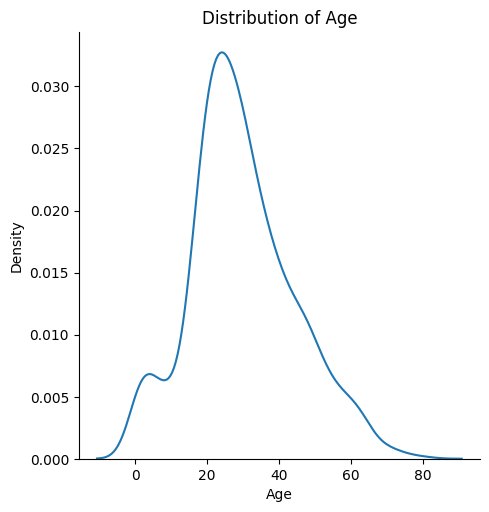

In [6]:
sns.displot(x=titanic_all_ori['Age'], kind='kde').set(title='Distribution of Age') 
display(titanic_all.describe()['Age'])

In [7]:
title_age = {}
unique_titles = titanic_all['Name'] \
                .apply(lambda x: x.split(',')[1].split('.')[0].strip()).unique()

for title in unique_titles:
    title_age[title] = float(titanic_all.loc[titanic_all['Name'] \
                             .apply(lambda x: x.split(',')[1].split('.')[0].strip()) == title, 'Age'] \
                             .mean() \
                             .round())

titanic_all['Age'] = titanic_all.apply(lambda row: title_age[row['Name'].split(',')[1].split('.')[0].strip()] if np.isnan(row['Age']) else row['Age'], axis=1)

count    1309.000000
mean       29.869114
std        13.188728
min         0.170000
25%        22.000000
50%        30.000000
75%        36.000000
max        80.000000
Name: Age, dtype: float64

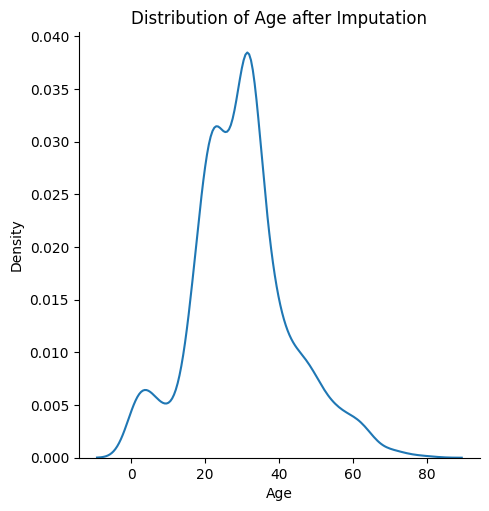

In [8]:
sns.displot(x=titanic_all['Age'], kind='kde').set(title='Distribution of Age after Imputation')
display(titanic_all.describe()['Age'])

## Cabin

For Cabin We might consider dropping it latter in Feature Engineering Section because the missing data is to much (**above 75%** missing for either train and test data)

There might be an alternative which is we can just fill it based on fare. 

In [41]:
# Replace Nan or missing value with 'N' first
titanic_train.loc[titanic_train['Cabin'].isna(), 'Cabin'] = 'N'
titanic_test.loc[titanic_test['Cabin'].isna(), 'Cabin'] = 'N'

# Adding new feature column with first letter in that Cabin Column
titanic_train['CabinCode'] = titanic_train['Cabin'].apply(lambda x: str(x).split(' ')[0][0]).str.lower()
titanic_test['CabinCode'] = titanic_test['Cabin'].apply(lambda x: str(x).split(' ')[0][0]).str.lower()

# mean fare for each Cabin
train_cabin_fare = titanic_train.groupby('CabinCode')['Fare'].mean()
test_cabin_fare = titanic_test.groupby('CabinCode')['Fare'].mean()

# count for each Cabin
train_cabin_count = titanic_train.groupby('CabinCode')['Fare'].count()
test_cabin_count = titanic_test.groupby('CabinCode')['Fare'].count()

# datafram full of train and test mean and count
cabin_count_fare = pd.concat(objs=[train_cabin_count, test_cabin_count, 
                                   train_cabin_fare, test_cabin_fare], 
                             keys=['TrainCount', 'TestCount', 
                                   'TrainFare', 'TestFare'], 
                             axis=1)
cabin_count_fare['Cabin'] = train_cabin_count.index

# Exclued cabin n (n=missing_value)
cabin_count_fare_exclude_cabin_n = cabin_count_fare[cabin_count_fare['Cabin']!='n'] 


fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
# Cabin vs TrainCount/ TestCount
ax[0][0].set_title('Train: Cabin vs TrainCount')
sns.barplot(x='Cabin',
            y='TrainCount',
            data=cabin_count_fare_exclude_cabin_n,
            ax=ax[0][0])

ax[1][0].set_title('Test: Cabin vs TestCount')
sns.barplot(x='Cabin',
            y='TestCount', 
            data=cabin_count_fare_exclude_cabin_n,
            ax=ax[1][0])

# Cabin vs TrainCount/ TestCount
ax[0][1].set_title('Train: Cabin vs TrainFare')
sns.lineplot(x='Cabin',
            y='TrainFare',
            data=cabin_count_fare_exclude_cabin_n,
            ax=ax[0][1])

ax[1][1].set_title('Test: Cabin vs TestFare')
sns.lineplot(x='Cabin',
            y='TestFare', 
            data=cabin_count_fare_exclude_cabin_n,
            ax=ax[1][1])

plt.show()



It is clear that cabin 'b', 'c', and 'd' is the has the highest fare.

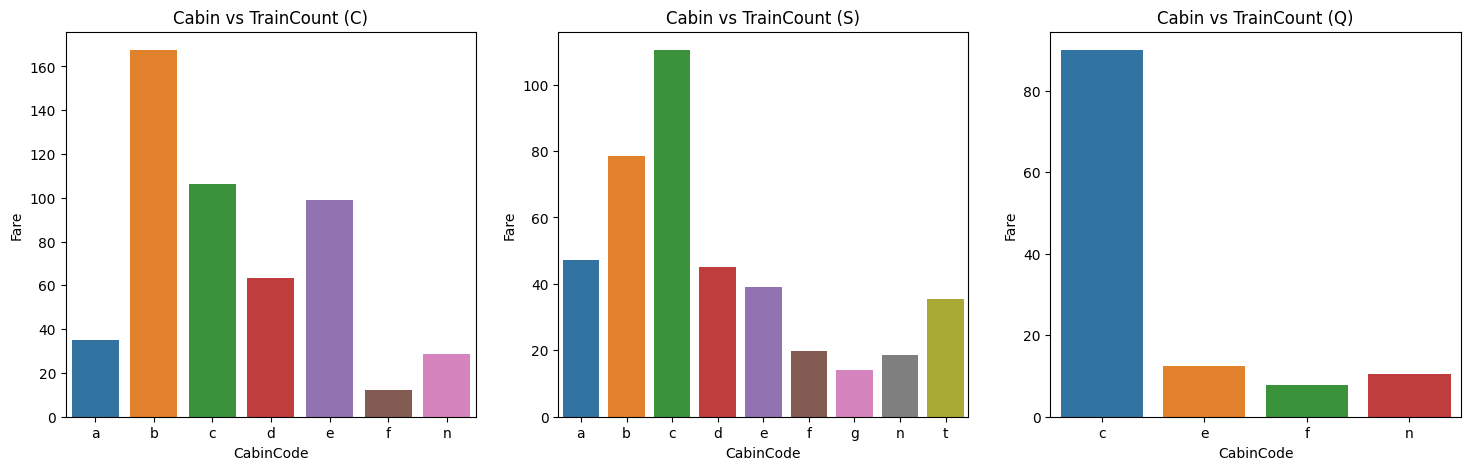

In [128]:
# Replace Nan or missing value with 'N' first
titanic_all.loc[titanic_all['Cabin'].isna(), 'Cabin'] = 'N'

# Adding new feature column with first letter in that Cabin Column
titanic_all['CabinCode'] = titanic_all['Cabin'].apply(lambda x: str(x).split(' ')[0][0].strip()).str.lower()

# mean fare for each Cabin
all_cabin_fare = titanic_all.groupby(['CabinCode', 'Embarked'], as_index=False)['Fare'].mean()

# count for each Cabin
all_cabin_count = titanic_all.groupby(['CabinCode', 'Embarked'], as_index=False)['Fare'].count()

# datafram full of train and test mean and count
cabin_count_fare = pd.concat(objs=[all_cabin_count['CabinCode'], 
                                   all_cabin_count['Embarked'],
                                   all_cabin_count['Fare'],
                                   all_cabin_fare['Fare']],
                             axis=1)
cabin_count_fare.columns = ['CabinCode', 'Embarked', 'Count', 'Fare']


# # Exclued cabin n (n=missing_value)
# cabin_count_fare_exclude_cabin_n = cabin_count_fare.loc[cabin_count_fare['CabinCode']!='n'] 

unique_embarked = cabin_count_fare['Embarked'].unique()
fig, ax = plt.subplots(nrows=1, ncols=len(cabin_count_fare['Embarked'].unique()), figsize=(18, 5))
# Cabin vs Count (C)
sns.barplot(x='CabinCode',
            y='Fare',
            data=cabin_count_fare.loc[cabin_count_fare['Embarked'] == unique_embarked[0]],
            ax=ax[0]).set(title='Cabin vs TrainCount ({})'.format(unique_embarked[0]))

sns.barplot(x='CabinCode',
            y='Fare',
            data=cabin_count_fare.loc[cabin_count_fare['Embarked'] == unique_embarked[1]],
            ax=ax[1]).set(title='Cabin vs TrainCount ({})'.format(unique_embarked[1]))

sns.barplot(x='CabinCode',
            y='Fare',
            data=cabin_count_fare.loc[cabin_count_fare['Embarked'] == unique_embarked[2]],
            ax=ax[2]).set(title='Cabin vs TrainCount ({})'.format(unique_embarked[2]))
plt.show()

This shows, that each fare differs based on CabinCode and Embarked (how far they were travelling for)

Rather than filling cabin value according to fare. Create a new feature column 'HasCabin' because the data is collected after accident. If the value of 'HasCabin' is 0 that means that the passenger might be dead because he can't report where the location of his cabin.

In [130]:
titanic_all['HasCabin'] = titanic_all['Cabin']\
                          .apply(lambda x: 0 if str(x) == 'N' else 1)

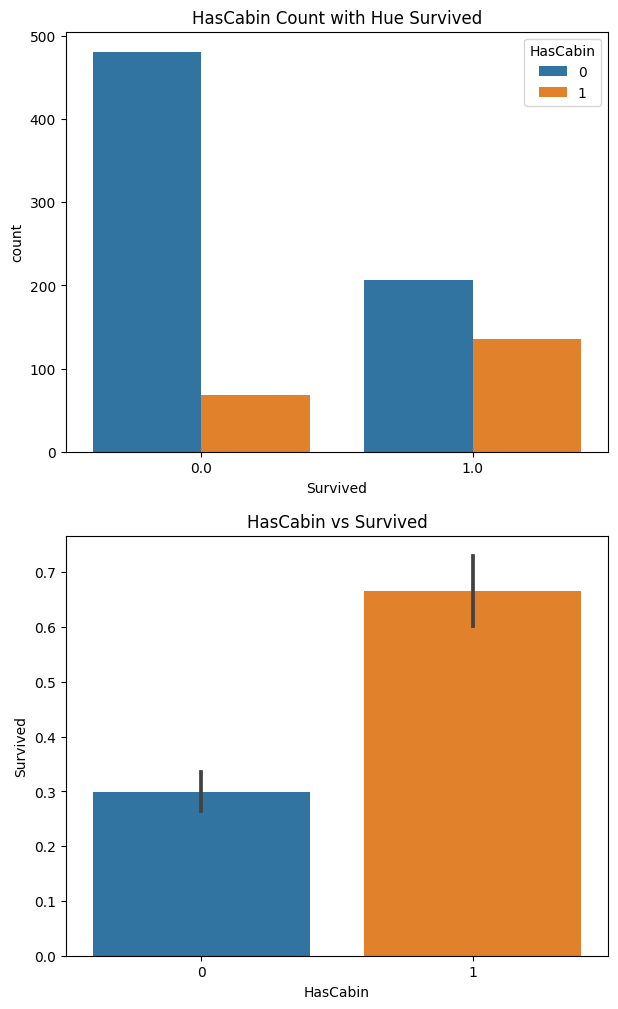

In [138]:
fig, ax = plt.subplots(figsize=(7,12), nrows=2)
ax[0].set_title('HasCabin Count with Hue Survived')
sns.countplot(x='Survived', hue='HasCabin',
              data=titanic_all, ax=ax[0])

ax[1].set_title('HasCabin vs Survived')
sns.barplot(x='HasCabin', y='Survived', data=titanic_all, ax=ax[1])
plt.show()

As shown above people that HasCabin value equals 1 has higher chance of surviving the titanic (from training data).

## Embarked
Data that has missing value on Embarked column is on the train data. We can just need to replace it with data that is frequent on the column which is 'S' but we might have a chance of filling with a wrong value because embarked mean where the traveler got on board from. There might be a correlation between Fare and the location (Embarked) the passenger embarked and of course Pclass (represents socio-economic status or SES).

We only need to find out the price (per person) to compare with other prices (per person) to allocate the missing embarked port.

Create new Column called FamilySize which indicates how many families they travelled with

> ***FamilySize = Parch + SibSp + 1*** (+1 mean include the passenger itself)

Create new Column called FriendSize which indicates how many families they travelled with

> ***FriendSize = Count(PassengerID with same Ticket)***

In the end we will create a GroupSize which filled with inferences of total group size that travelled with a passenger

> ***FriendSize = Max(FamilySize, FriendSize)***

Finally, to determine FarePerPerson will be computed like this

> ***FarePerPerson = Fare/FriendSize***

In [ ]:
# # Calculate FamilySize
# # titanic_train['FamilySize'] = titanic_train['SibSp'] + titanic_train['Parch'] + 1
# # titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch'] + 1
# titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch'] + 1

# # Calculate FriendSize for train
# friend_size = titanic_train.groupby('Ticket')['PassengerId'].count()
# for key, val in friend_size.items():
#   titanic_train.loc[titanic_train['Ticket'] == key, 'FriendSize'] = val

# # Calculate FriendSize for test
# friend_size = titanic_test.groupby('Ticket')['PassengerId'].count()
# for key, val in friend_size.items():
#   titanic_test.loc[titanic_test['Ticket'] == key, 'FriendSize'] = val

# # Find GroupSize
# titanic_train['GroupSize'] = titanic_train[['FamilySize', 'FriendSize']].max(axis=1)
# titanic_test['GroupSize'] = titanic_test[['FamilySize', 'FriendSize']].max(axis=1)

# # Calculate FarePerPerson
# titanic_train['FarePerPerson'] = titanic_train['Fare'] / titanic_train['FriendSize']
# titanic_test['FarePerPerson'] = titanic_test['Fare'] / titanic_test['FriendSize']

In [139]:
# Calculate FamilySize
titanic_all['FamilySize'] = titanic_all['SibSp'] + titanic_all['Parch'] + 1

# Calculate FriendSize
friend_size = titanic_all.groupby('Ticket')['PassengerId'].count()
for key, val in friend_size.items():
    titanic_all.loc[titanic_all['Ticket'] == key, 'FriendSize'] = val


# Find GroupSize
titanic_all['GroupSize'] = titanic_all[['FamilySize', 'FriendSize']].max(axis=1)

# Calculate FarePerPerson
titanic_all['FarePerPerson'] = titanic_all['Fare'] / titanic_all['FriendSize']

In [140]:
titanic_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          1309 non-null   object 
 11  Embarked       1307 non-null   object 
 12  train_test     1309 non-null   int64  
 13  CabinCode      1309 non-null   object 
 14  HasCabin       1309 non-null   int64  
 15  FamilySize     1309 non-null   int64  
 16  FriendSize     1309 non-null   float64
 17  GroupSize      1309 non-null   float64
 18  FarePerP

Due to high standard deviation (above +2 or below -2), using mean for determining Embarked because the data is to far from the actual value (ouutlier).

Embarked,C,Q,S
Pclass,,,
1,34.6500,30.00,26.5500
2,13.8583,12.35,11.5000
3,7.2271,7.75,7.7958


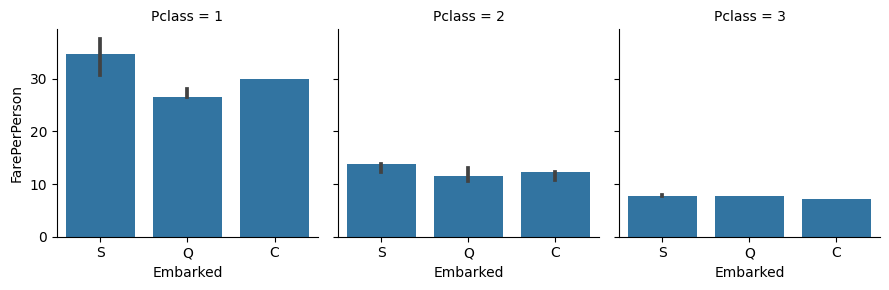

In [141]:
display(pd.pivot_table(data=titanic_all, 
               index='Pclass', 
               columns='Embarked', 
               values='FarePerPerson', 
               aggfunc='median'))

facet_grid_med = sns.FacetGrid(data=titanic_all, col='Pclass', 
                               sharey=True, sharex=True)
facet_grid_med.map_dataframe(sns.barplot, 
                             x='Embarked', 
                             y='FarePerPerson', 
                             estimator=np.median)
plt.show()

As we can see the FarePerPerson is high on Pclass=1.


In [142]:
df_med = pd.pivot_table(data=titanic_all, 
               index='Pclass', 
               columns='Embarked', 
               values='FarePerPerson', 
               aggfunc='median')


# df.medtitanic_train[titanic_train['Embarked'].isna()]
# t = pd.DataFrame(df_med, index=df_med.index)
# t[0]
for i in df_med[df_med.index==1]:
    print(i)
    print(titanic_all.loc[titanic_all['Embarked'].isna(), 'FarePerPerson'] - df_med[df_med.index==1][i].values)

C
61     5.35
829    5.35
Name: FarePerPerson, dtype: float64
Q
61     10.0
829    10.0
Name: FarePerPerson, dtype: float64
S
61     13.45
829    13.45
Name: FarePerPerson, dtype: float64


Fill Embarked C on the missing value because it is close to FarePerPerson where Embarked is 'C'.

In [143]:
titanic_all.loc[titanic_all['Embarked'].isna(), 'Embarked'] = 'C'

In [144]:
titanic_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          1309 non-null   object 
 11  Embarked       1309 non-null   object 
 12  train_test     1309 non-null   int64  
 13  CabinCode      1309 non-null   object 
 14  HasCabin       1309 non-null   int64  
 15  FamilySize     1309 non-null   int64  
 16  FriendSize     1309 non-null   float64
 17  GroupSize      1309 non-null   float64
 18  FarePerP

## Fare
Simply fill it with mean of fare with the median where the passenger embarked

In [145]:
titanic_all[titanic_all['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,CabinCode,HasCabin,FamilySize,FriendSize,GroupSize,FarePerPerson
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,N,S,1,n,0,1,1.0,1.0,NaN


In [149]:
titanic_all.loc[titanic_all['Embarked']=='S', 'FarePerPerson'].median()

8.1125

In [150]:
if titanic_all['Fare'].isna().sum() > 0:
    titanic_all.loc[titanic_all['Fare'].isna(), ['Fare', 'FarePerPerson']] = titanic_all.loc[titanic_all['Embarked']=='S', 'FarePerPerson'].median() * titanic_all.loc[titanic_all['Fare'].isna(), 'FriendSize']

In [151]:
print(titanic_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1309 non-null   float64
 10  Cabin          1309 non-null   object 
 11  Embarked       1309 non-null   object 
 12  train_test     1309 non-null   int64  
 13  CabinCode      1309 non-null   object 
 14  HasCabin       1309 non-null   int64  
 15  FamilySize     1309 non-null   int64  
 16  FriendSize     1309 non-null   float64
 17  GroupSize      1309 non-null   float64
 18  FarePerP

# Exploratory Data Analysis
This section contains data visualization and analysis to gain insights and characteristics of the data.

In [152]:
titanic_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1309 non-null   float64
 10  Cabin          1309 non-null   object 
 11  Embarked       1309 non-null   object 
 12  train_test     1309 non-null   int64  
 13  CabinCode      1309 non-null   object 
 14  HasCabin       1309 non-null   int64  
 15  FamilySize     1309 non-null   int64  
 16  FriendSize     1309 non-null   float64
 17  GroupSize      1309 non-null   float64
 18  FarePerP

## Plot Data That are Numeric

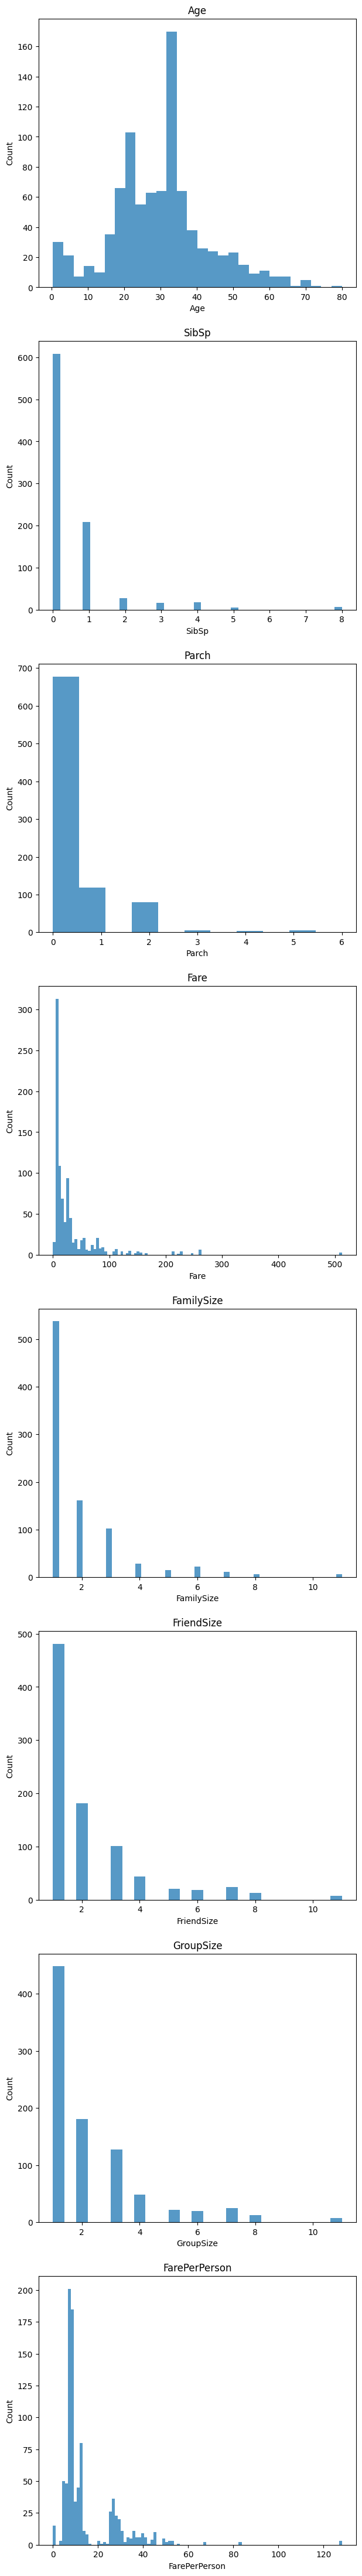

In [158]:
titanic_train = titanic_all[titanic_all['train_test']==0]
titanic_test = titanic_all[titanic_all['train_test']==1]
titanic_num = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FriendSize', 'GroupSize', 'FarePerPerson']

fig, ax = plt.subplots(nrows=len(titanic_num), figsize=[7, len(titanic_num)*7])

for i, col in enumerate(titanic_num):
    sns.histplot(titanic_train[col], linewidth=0, ax=ax[i])
    ax[i].set_title(col)

plt.show()

Based on the distribution of the data we can see that 'SibSp', 'Parch', and 'Fare' columns are are right skewed. This probem will be solved using scaling or normalization to decrease the standard deviation as well which affect our model if we didn't do so.

## Plot Data That are Categorical
The main reason is to see whether there are any categorical variables that needs feature engineering.

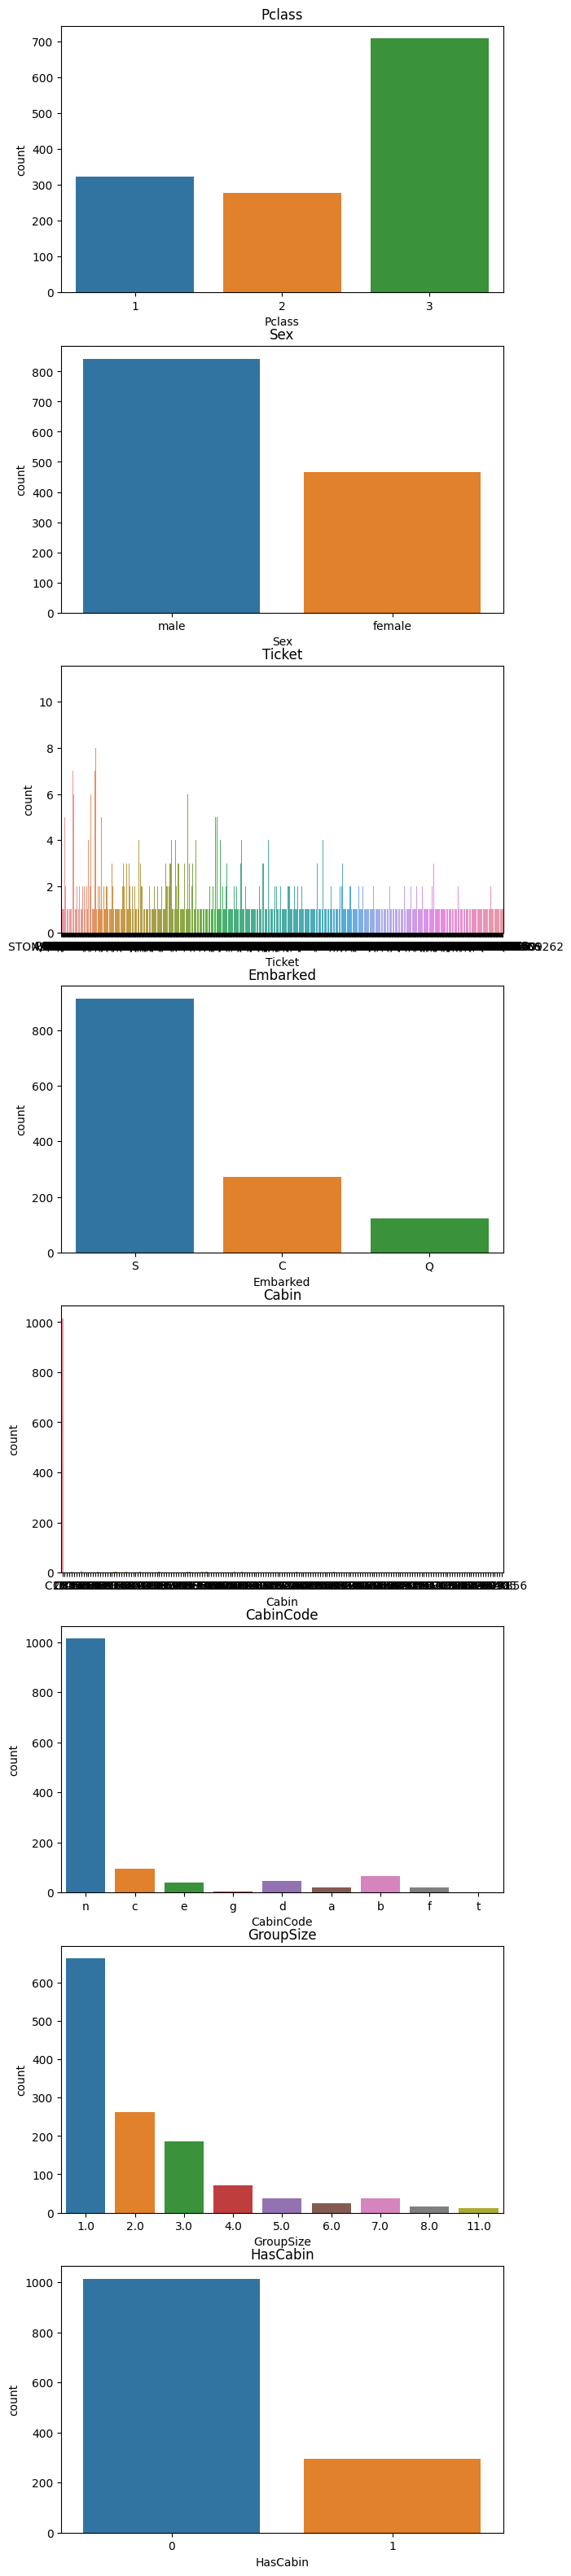

In [160]:
titanic_cat = ['Pclass', 'Sex', 'Ticket', 'Embarked', 'Cabin', 'CabinCode', 'GroupSize', 'HasCabin']

fig, ax = plt.subplots(nrows=len(titanic_cat), figsize=[7, len(titanic_cat)*5])

for i, col in enumerate(titanic_cat):
    sns.countplot(data=titanic_all, x=col, linewidth=0, ax=ax[i])
    ax[i].set_title(col)
plt.show()

Cabin and Ticket Columns need feature engineering because the data is too vary for the machine or even humans to interpret.

## Plot Other Feature
This part is for finding which feature that correlates to the survivality

### Count Plot Survival Based On Sex

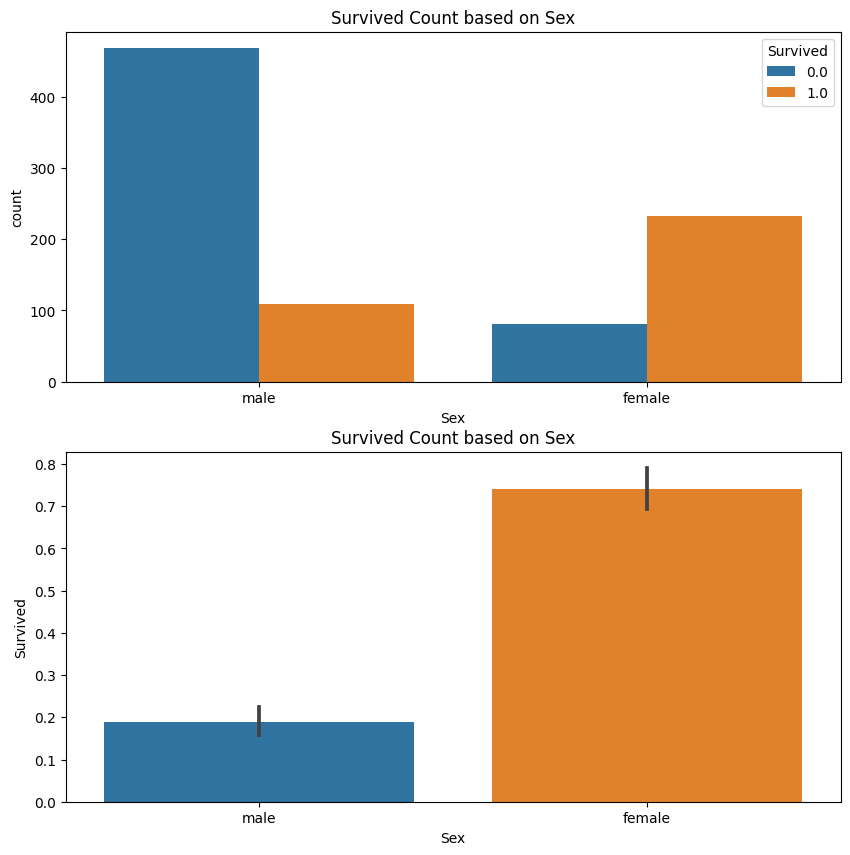

,Survived
Sex,
female,0.742038
male,0.188908


Male Survived Percentage 12.23 %
Male Not Survived Percentage 52.53 %

Female Survived Percentage 26.15 %
Female Not Survived Percentage 9.091 %


In [161]:
# Plot counting survival based on sex
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

sns.countplot(x='Sex', hue='Survived', data=titanic_train, ax=ax[0])\
              .set(title='Survived Count based on Sex')

sns.barplot(x='Sex', y='Survived', data=titanic_train, ax=ax[1])\
              .set(title='Survived Count based on Sex')
plt.show()

# male and female survivability compare to each own gender

# (percentage how many female survived from all female passengers)
# female_percentage = female_survived.sum / female_passengers.count 

# (percentage how many male survived from all male passengers)
# male_percentage = male_survived.sum / female_passengers.count

display(pd.pivot_table(data=titanic_train,
               index='Sex',
               aggfunc={'Survived': np.mean}))

# male and female survivability percentage based compare to all passengers 
len_data = len(titanic_train)

bool_survived = titanic_train['Survived'] == 1
bool_not_survived = titanic_train['Survived'] == 0

bool_male = titanic_train['Sex'] == 'male'
bool_female = titanic_train['Sex'] == 'female'

bool_male_survived = titanic_train.loc[bool_survived & bool_male]
bool_male_not_survived = titanic_train.loc[bool_not_survived & bool_male]

bool_female_survived = titanic_train.loc[bool_survived & bool_female]
bool_female_not_survived = titanic_train.loc[bool_not_survived & bool_female]

# (percentage how many male survived from all passengers)
print('Male Survived Percentage', '{0:.4g}'.format(len(bool_male_survived)/len_data*100), '%')
# (percentage how many male not survived from all passengers)
print('Male Not Survived Percentage', '{0:.4g}'.format(len(bool_male_not_survived)/len_data*100), '%\n')
# (percentage how many female survived from all passengers)
print('Female Survived Percentage', '{0:.4g}'.format(len(bool_female_survived)/len_data*100), '%')
# (percentage how many female not survived from all passengers)
print('Female Not Survived Percentage', '{0:.4g}'.format(len(bool_female_not_survived)/len_data*100), '%')

From the plot, we can conclude that female has a higher chance of surviving in the titanic accident.

*74,2%* from all female passenger survived

*18%* from all male passenger survived

**From all passengers**:
1. *12.23%* of passengers which are **male survived**
1. *52.53%* of passengers which are **male not survived**
1. *26.15%* of passengers which are **female survived**
1. *9.09%* of passengers which are **female not survived**


### Heat Map Survived vs Pclass Columns

Survived  0.0  1.0
Pclass            
1          80  136
2          97   87
3         372  119


<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

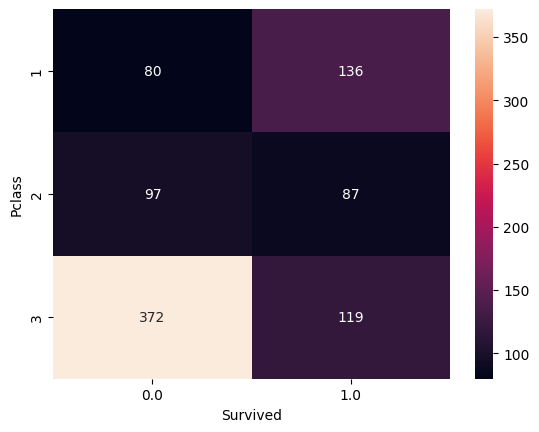

In [162]:
# Create a heat map Survived vs Pclass Columns
grouped_by_survived_pclass = titanic_all.groupby(['Pclass', 'Survived'])
# convert index survived to a column using unstack()
print(grouped_by_survived_pclass.size().unstack())

sns.heatmap(grouped_by_survived_pclass.size().unstack(), annot=True, fmt='d')


People on the first class has the highest chance of survivability.

### Countplot Sex vs Survived With Hue Pclass

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

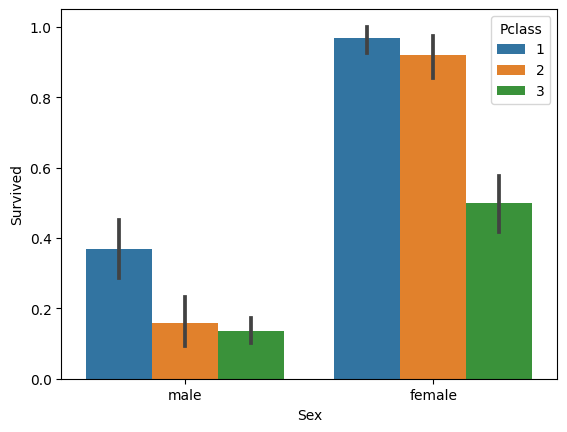

In [163]:
sns.barplot(x='Sex',
            hue='Pclass',
            y='Survived', 
            data=titanic_all)

As we can see female at the first class (Pclass=1) has the highest chance of survivability. While male at the third class has the lowest chance of survivability. So far, female on the first class has the highest chance of survivability.


### Histplot Age vs Survived

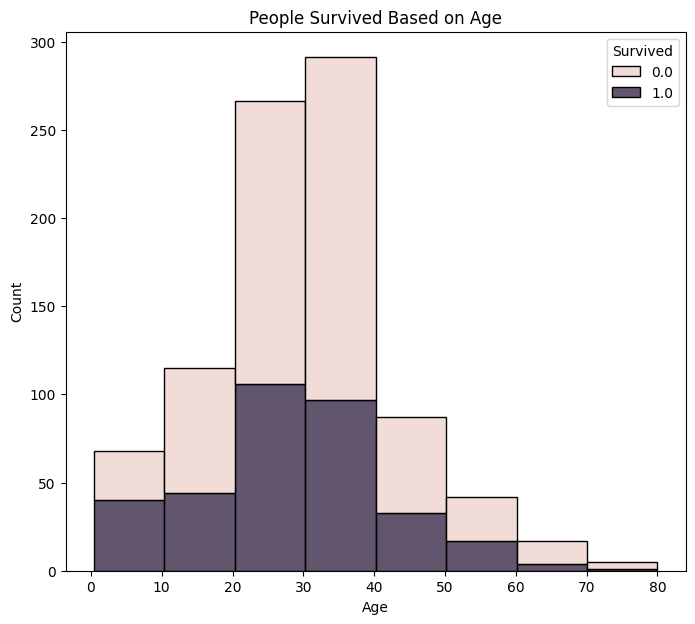

In [164]:
# Histplot Age vs Survived
plt.figure(figsize=[8,7])
plt.title('People Survived Based on Age')
sns.histplot(x='Age',
            data=titanic_all,
            hue='Survived',
            multiple='stack',
            bins=8)
plt.show()

<AxesSubplot:xlabel='Sex', ylabel='Age'>

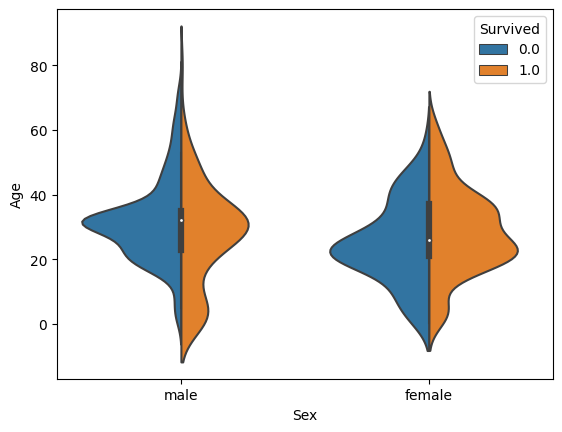

In [165]:
sns.violinplot(x ="Sex", y ="Age", hue ="Survived",
data = titanic_all, split = True)

As we can see reasonable age that mostly survived the titanic is in range 20-40. People with younger age tend to survive rather that the old people.

Female in range of 20-45 years has high chance or survival. Male Children has a high chance of survival.

Based on https://med.libretexts.org/Courses/American_Public_University/APUS%3A_An_Introduction_to_Nutrition_(Byerley)/Text/12%3A_Maternal_Infant_Childhood_and_Adolescent_Nutrition/12.02%3A_The_Human_Life_Cycle#:~:text=The%20major%20stages%20of%20the%20human%20lifecycle%20include%20pregnancy%2C%20infancy,age%2C%20and%20the%20senior%20years.

The major stages in human lifecycle are defined as follows:
1. Pregnancy. The development of a zygote into an embryo and then into a fetus in preparation for childbirth (**Won't be used**).
2. Infancy: 0-1 year
3. Toddler years: 2 - 3 years
4. Childhood: 4 - 8 years 
5. Puberty: 9 - 13 years
6. Older adolescence: 14 - 18 years
7. Adulthood: 19 - 30 years
8. Middle age: 31 - 50 years
9. Senior years: >= 51 years

In [166]:
stages = ['infancy', 'toddler', 'childhood', 'puberty', 'older adolescence', 
          'adulthood', 'middle age', 'senior years']

def grouped_ages(data):
    if data <= 1:
        return 'infancy'
    elif data <= 3:
        return 'toddler'
    elif data <= 8:
        return 'childhood'
    elif data <= 13:
        return 'puberty'
    elif data <= 18:
        return 'older adolescence'
    elif data <= 30:
        return 'adulthood'
    elif data <= 50:
        return 'middle age' 
    else:
        return 'senior years'


titanic_all['AgeCategory'] = titanic_all['Age'].apply(grouped_ages)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'adulthood'),
  Text(1, 0, 'middle age'),
  Text(2, 0, 'senior years'),
  Text(3, 0, 'toddler'),
  Text(4, 0, 'older adolescence'),
  Text(5, 0, 'childhood'),
  Text(6, 0, 'puberty'),
  Text(7, 0, 'infancy')])

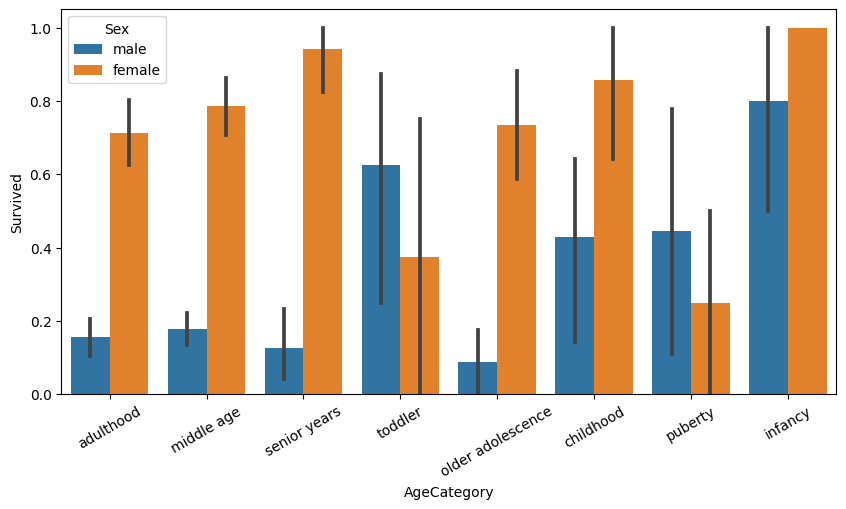

In [167]:
plt.figure(figsize=[10, 5])
sns.barplot(x='AgeCategory', y='Survived', hue='Sex', data=titanic_all)
plt.xticks(rotation=30)

As we can see Female has the highest chance of being survived especially infancy(<=1) and senior (>50). For Male, toddler and infancy has high chance of surviving the accident. 

### Histplot Embarked vs Survived

<AxesSubplot:title={'center':'People Who Survived Based on Embarked'}, xlabel='Embarked', ylabel='count'>

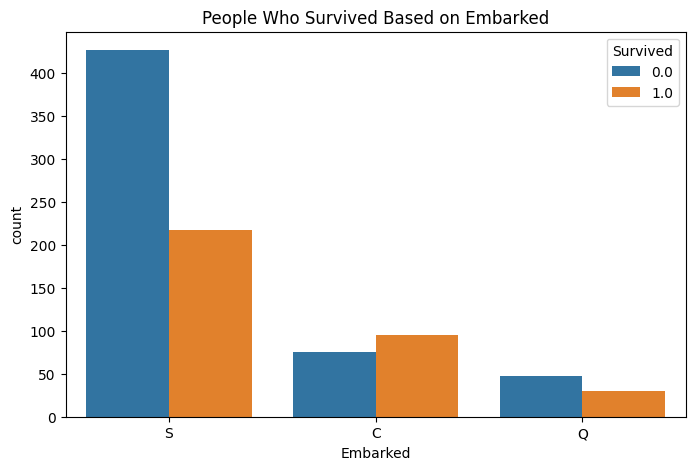

In [168]:
plt.figure(figsize=[8,5])
plt.title('People Who Survived Based on Embarked')
sns.countplot(x='Embarked', data=titanic_all, hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

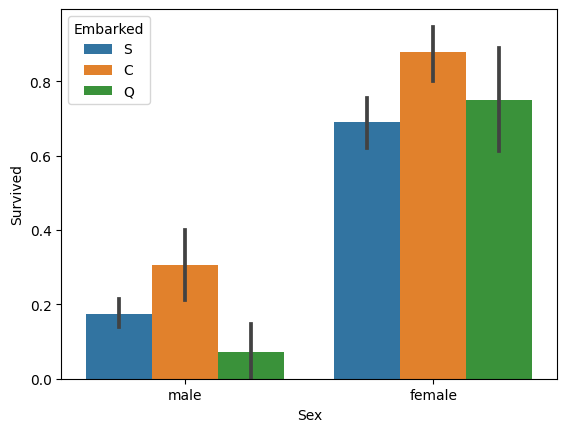

In [169]:
sns.barplot(data=titanic_all, 
            hue='Embarked', 
            x='Sex', 
            y='Survived')

female who embarked from C has higher percentage for surviving the titanic accident

### Factor Plot Correlation of Survivability From Traveling with Accompanied or Not.

C:\Users\USER\.virtualenvs\titanic-survival-model-YaXBF1wM\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\.virtualenvs\titanic-survival-model-YaXBF1wM\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


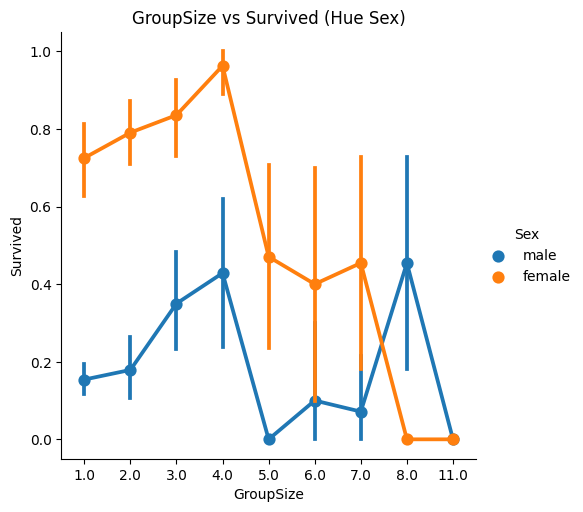

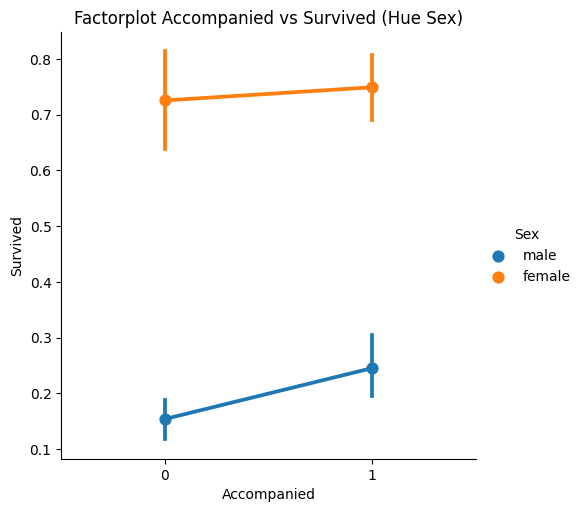

In [170]:
# Adding new column 'Accompanied' which has a meaning if the person travelling alone or not

bool_groupsize = titanic_all['GroupSize'] > 1
titanic_all['Accompanied'] = 0
titanic_all.loc[bool_groupsize, 'Accompanied'] = 1

sns.factorplot(x='GroupSize', y='Survived', hue='Sex', data=titanic_all)\
.set(title='GroupSize vs Survived (Hue Sex)')

sns.factorplot(x='Accompanied', y='Survived', hue='Sex', data=titanic_all)\
.set(title='Factorplot Accompanied vs Survived (Hue Sex)')
plt.show()


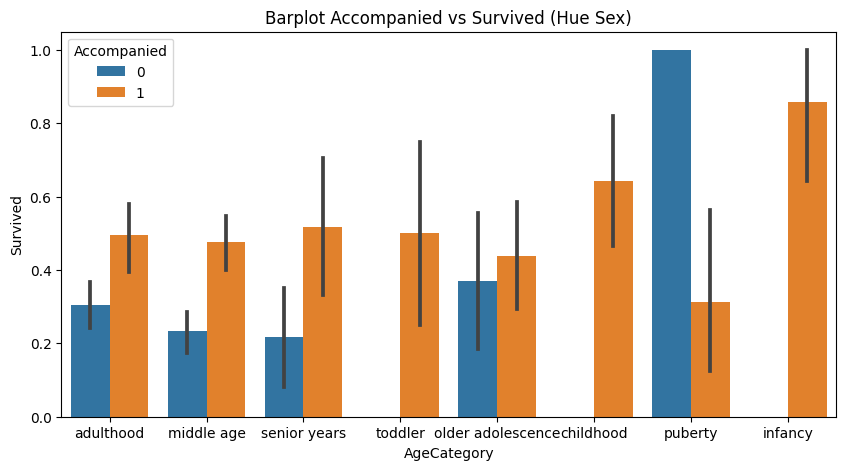

In [172]:
plt.figure(figsize=(10,5))
sns.barplot(x='AgeCategory', y='Survived', hue='Accompanied', data=titanic_all)\
.set(title='Barplot Accompanied vs Survived (Hue Sex)')
plt.show()


Most of the passnger that are accompanied has high change than those that aren't accompanied

### Bar Plot and Histogram Plot on Survivability Based on Fare

In [173]:
# Split Fare into 4 quantile
titanic_all['FarePerPersonBins'] = pd.qcut(titanic_all['FarePerPerson'], 4)

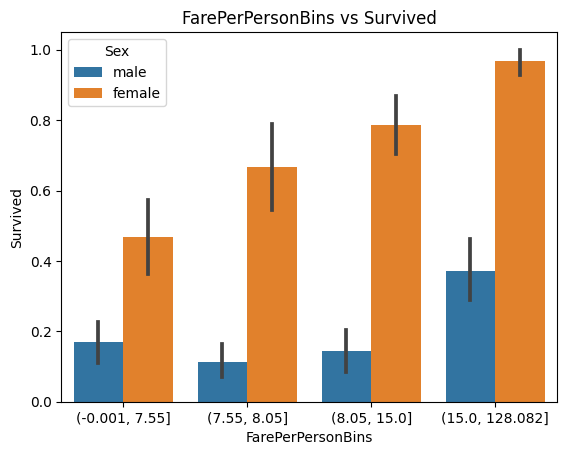

Pclass,1,2,3
Survived,,,
0.0,64.684007,19.412328,13.669364
1.0,95.608029,22.055700,13.694887


Pclass,1,2,3
Survived,,,
0.0,44.7500,13.0,8.0500
1.0,77.9583,21.0,8.5167


In [176]:
# fig, ax = plt.subplots(figsize=(15,15), nrows=2, ncols=1)

sns.barplot(x='FarePerPersonBins', y='Survived',
            hue='Sex',
            data=titanic_all)\
            .set_title('FarePerPersonBins vs Survived')

# ax[1].set_title('Countplot FareBins with Hue of Survived')
# sns.countplot(x='FarePerPersonBins', hue='Survived', 
#               data=titanic_all, ax=ax[1])
plt.show()

display(pd.pivot_table(titanic_train, index='Survived', columns='Pclass', values='Fare', aggfunc='mean'))
display(pd.pivot_table(titanic_train, index='Survived', columns='Pclass', values='Fare', aggfunc='median'))

People who pay a lot for the ticket has a high survival rate. We can see that the mean for each people who survived has a higher Fare than those who not survived.

### Plot Survivability Based on Ticket

In [177]:
titanic_all['TicketCode'] = titanic_all['Ticket'].apply(lambda x: x.split(' ')[0].replace('.', '').replace('/', ''))\
    .apply(lambda x: 'n' if x.isnumeric() else x)\
    .str.lower()

In [179]:
np.sort(titanic_all['TicketCode'].unique())
tickets_type = ['a', 'c', 'fa', 'fc', 'line', 'n', 'p', 'sc', 
                'so', 'sp', 'sotono', 'sp','stono', 'sw', 'w']

for t in tickets_type:
    titanic_all.loc[titanic_all['TicketCode'].str.match(f'^({t}.*)'), 'TicketCode'] = t


In [180]:
titanic_all['TicketCode'].unique()

array(['a', 'p', 'stono', 'n', 'c', 'sc', 'sp', 'so', 'w', 'fa', 'line',
       'fc', 'sw', 'lp'], dtype=object)

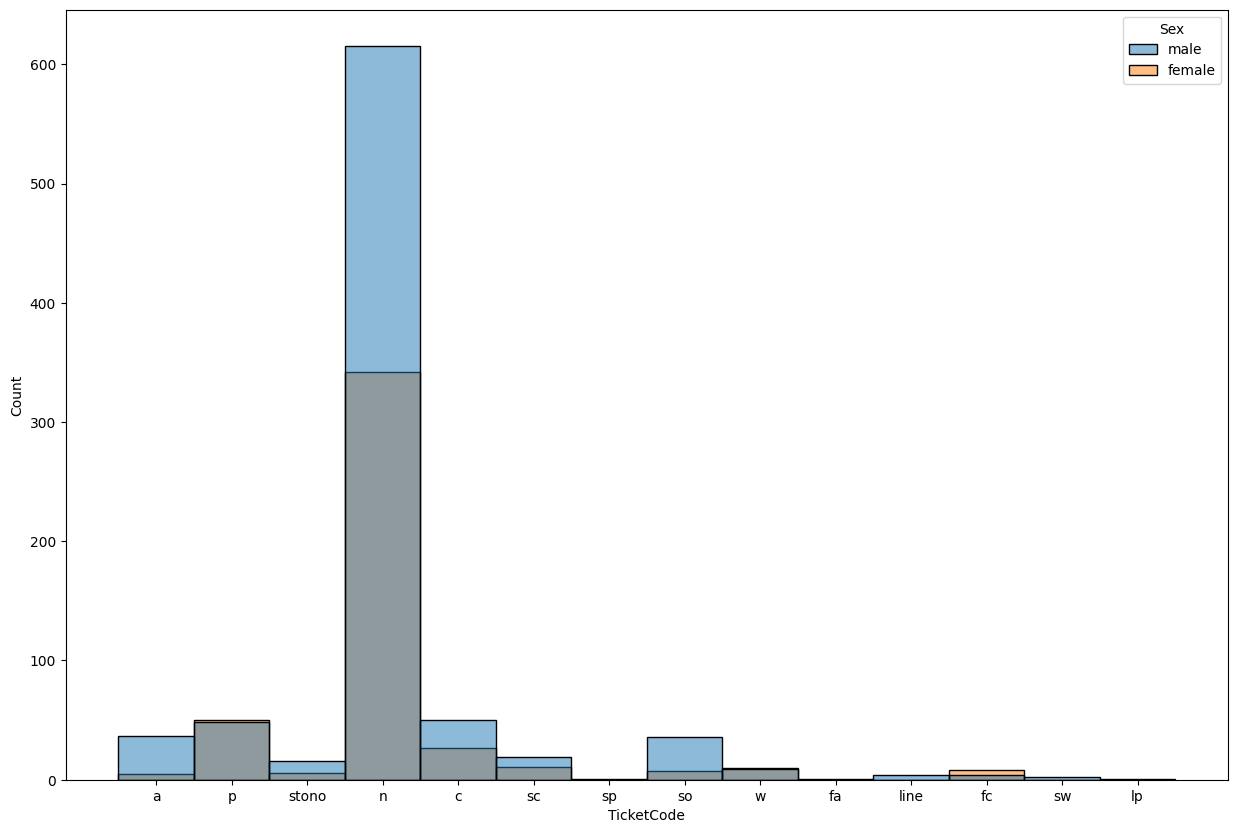

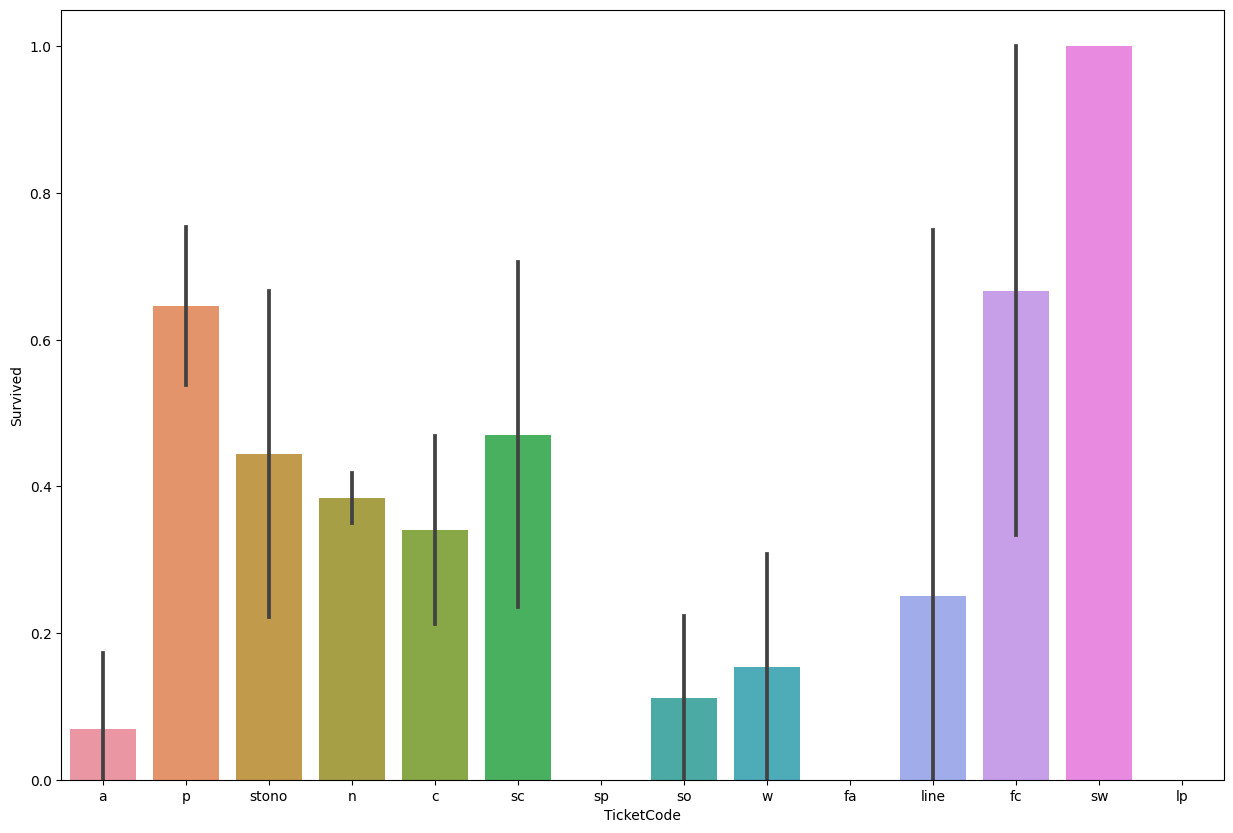

In [181]:
plt.figure(figsize=(15,10))
sns.histplot(x='TicketCode', hue='Sex', data=titanic_all)
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(x='TicketCode', y='Survived', data=titanic_all)
plt.show()

# display(pd.pivot_table(titanic_train, index='TicketCode', columns='Survived', values='PassengerId', aggfunc='count'))
# display(pd.pivot_table(titanic_train, index='TicketCode', columns='Survived', values='Fare', aggfunc='mean'))

Looks like ticket code didn't provide enough evidence whether those with expensive ticket fare survive the titanic.

In [182]:
# titanic_all['CabinCode'] = titanic_train['Cabin'].apply(lambda x: str(x).split(' ')[0][0]).str.lower()
# titanic_all['CabinCount'] = titanic_train['Cabin'].apply(lambda x: len(str(x).split(' ')))
titanic_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,CabinCode,HasCabin,FamilySize,FriendSize,GroupSize,FarePerPerson,AgeCategory,Accompanied,FarePerPersonBins,TicketCode
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,n,0,2,1.0,2.0,7.25000,adulthood,1,"(-0.001, 7.55]",a
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,c,1,2,2.0,2.0,35.64165,middle age,1,"(15.0, 128.082]",p
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,n,0,1,1.0,1.0,7.92500,adulthood,0,"(7.55, 8.05]",stono
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,c,1,2,2.0,2.0,26.55000,middle age,1,"(15.0, 128.082]",n
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,n,0,1,1.0,1.0,8.05000,middle age,0,"(7.55, 8.05]",n


<AxesSubplot:title={'center':'Survived vs HasCabin'}, xlabel='HasCabin', ylabel='count'>

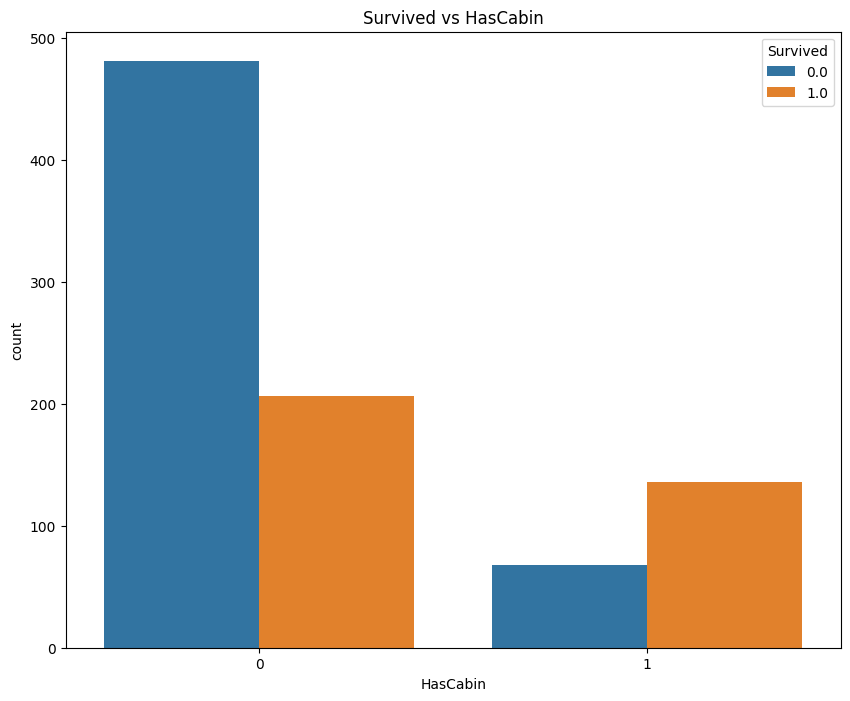

In [183]:
plt.figure(figsize=[10,8])
plt.title('Survived vs HasCabin')
sns.countplot(x='HasCabin', data=titanic_train, hue='Survived')

In [ ]:
# plt.figure(figsize=[10,8])
# plt.title('Survived vs Cabin Count')
# sns.countplot(x='CabinCount', data=titanic_all, hue='Survived')
# plt.show()
# display(pd.pivot_table(titanic_train, index='Cabin Count', columns='Survived', values='Fare', aggfunc='count'))
# display(pd.pivot_table(titanic_train, index='Cabin Count', columns='Survived', values='Fare', aggfunc='mean'))

Looks like people with multiple cabins (rich) most likely to survive but this doesn't ensure that. for example 4 cabins (all of them survive maybe they are a VIP that needs to be saved first) but others with 2 and 3 cabin has a slighly little change to survive

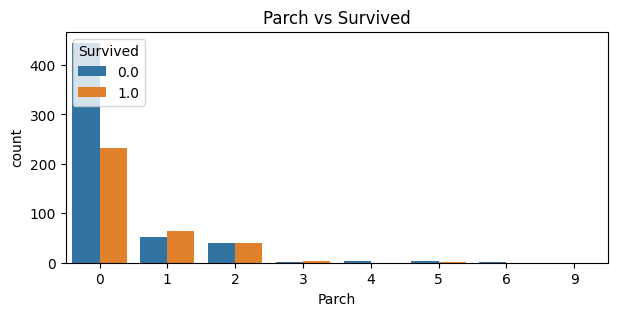

In [198]:
plt.figure(figsize=(7,3))
plt.title('Parch vs Survived')
sns.countplot(x='Parch', data=titanic_all, hue='Survived')
plt.show()

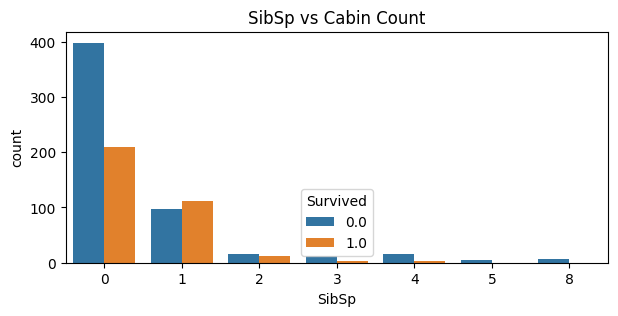

In [199]:
plt.figure(figsize=(7, 3))
plt.title('SibSp vs Cabin Count')
sns.countplot(x='SibSp', data=titanic_all, hue='Survived')
plt.show()

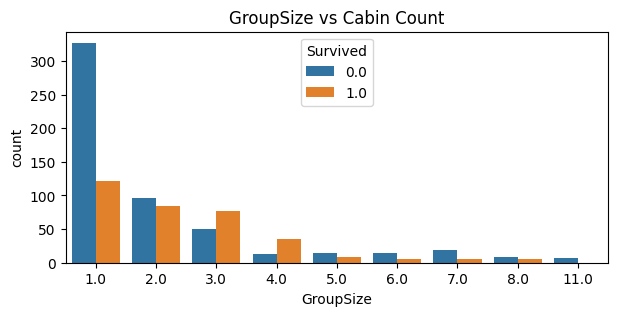

In [201]:
plt.figure(figsize=(7,3))
plt.title('GroupSize vs Cabin Count')
sns.countplot(x='GroupSize', data=titanic_all, hue='Survived')
plt.show()

One thing for sure that people who are travelling alone tend to survive because they only need to save themselves without worying others

### Countplot Title vs Survived

In [210]:
titanic_all['Title'] = titanic_all_ori['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

<AxesSubplot:xlabel='Title', ylabel='count'>

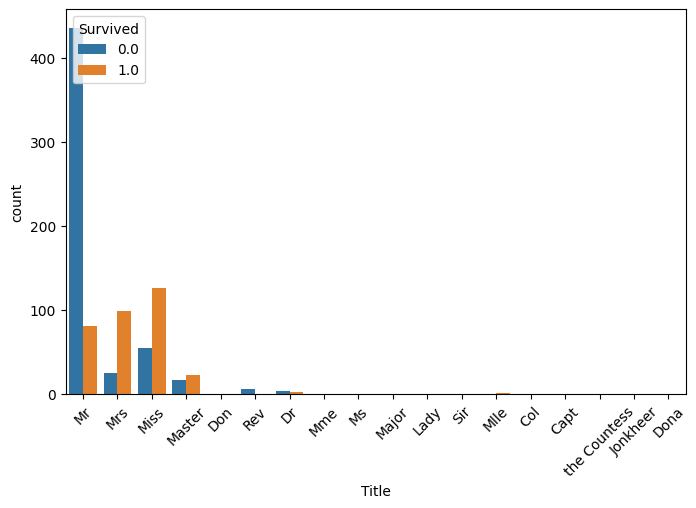

In [211]:
plt.figure(figsize=[8,5])
plt.xticks(rotation=45)
sns.countplot(x='Title', hue='Survived',data=titanic_all)

Grouped Title that have the same category

In [208]:
title_categorized = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Mme': 'Mrs',
    'Miss': 'Ms',
    'Mlle': 'Ms',
    'Ms': 'Ms',
    'Master': 'Master',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Other',
    'Rev': 'Other',
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'the Countess': 'Royalty',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Dona': 'Royalty',
}

In [212]:
titanic_all['Title'] = titanic_all['Title'].map(title_categorized)

<AxesSubplot:xlabel='Title', ylabel='count'>

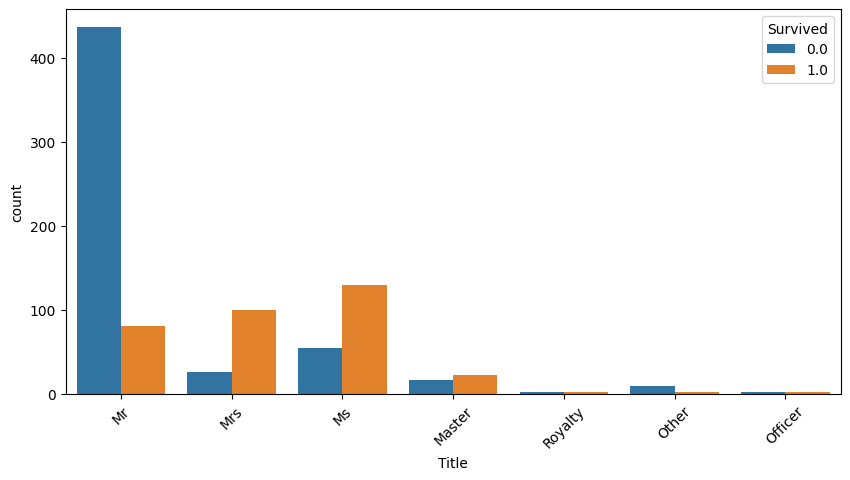

In [213]:
plt.figure(figsize=[10,5])
plt.xticks(rotation=45)
sns.countplot(x='Title', hue='Survived',data=titanic_all)

In [214]:
pd.pivot_table(data=titanic_all, index='Title', columns='Pclass',values='Survived', aggfunc='mean')

Pclass,1,2,3
Title,,,
Master,1.000000,1.000000,0.392857
Mr,0.345794,0.087912,0.112853
Mrs,0.976744,0.902439,0.500000
Ms,0.958333,0.942857,0.500000
Officer,0.400000,NaN,NaN
Other,0.600000,0.000000,NaN
Royalty,0.600000,NaN,NaN


We are going to change the title to a number where 'Mr' corresponds to 0, 'Mrs' corresponds to 1, 'Miss' corresponds to 2, 'Master' corresponds to 3 and others corresponds to 4

# Feature Engineering 

In [215]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
titanic_all_feat_eng = titanic_all.copy()

In [ ]:
titanic_all_feat_eng.head()

In [ ]:
titanic_all_feat_eng.info()

In [ ]:
# Select columns to be deleted because it is to vary
cols_to_be_deleted = ['PassengerId', 'Name', 'Cabin', 'Ticket']
for col in cols_to_be_deleted:
  if col in titanic_all_feat_eng.columns:
    titanic_all_feat_eng.drop(columns=col, inplace=True)

# Collect Columns that are Object or Category datatype to be encoded
col_obj_or_cat = []
for col in titanic_all_feat_eng.columns:
  if (titanic_all_feat_eng[col].dtype == 'object' or
      titanic_all_feat_eng[col].dtype == 'category'):
    col_obj_or_cat.append(col)


for col in col_obj_or_cat:
  print(col, titanic_all_feat_eng[col].unique())

In [ ]:
# Replace String or Object data dype features with numbers
title = {
    'Master': 0, 
    'Mr': 1, 
    'Mrs': 2, 
    'Miss': 3,
    }

# each age category is mapped to an integer value where the younger the person
# the lower their integer value. While for the older is the opposite. 
age_category = {
    'infancy': 0,
    'toddler':1,
    'childhood':2,
    'puberty':3,
    'older adolescence': 4,
    'adulthood':5,
    'middle age': 6,
    'senior years':7,
    }

fare_per_person_bins = {
    '(-0.001, 7.55]' : 0,
    '(7.55, 8.05]'   : 1,
    '(8.05, 15.0]'   : 2,
    '(15.0, 128.082]': 3,
    }


def encode_title(data):
  """encode Title column data"""
  if data in title.keys():
    return title[data]
  else:
    return len(title)

def encode_age_category(data):
  """encode AgeCategory column data"""
  if data in age_category.keys():
    return age_category[data]

def encode_fare_per_person_bins(data):
  """encode FarePerPersonBins column data"""
  data = str(data)
  if data in fare_per_person_bins.keys():
    return fare_per_person_bins[data]

In [ ]:
encoder = LabelEncoder()

if titanic_all_feat_eng['Title'].dtype == 'O':
  titanic_all_feat_eng['Title'] = \
  titanic_all_feat_eng['Title'].apply(encode_title)
  print('done encode Title')
  display(titanic_all_feat_eng['Title'].unique())

if titanic_all_feat_eng['AgeCategory'].dtype == 'O':
  titanic_all_feat_eng['AgeCategory'] = \
  titanic_all_feat_eng['AgeCategory'].apply(encode_age_category)
  print('done encode AgeCategory')
  display(titanic_all_feat_eng['AgeCategory'].unique())

if titanic_all_feat_eng['FarePerPersonBins'].dtype == 'category':
  titanic_all_feat_eng['FarePerPersonBins'] = \
  titanic_all_feat_eng['FarePerPersonBins'].apply(encode_fare_per_person_bins)
  print('done encode FarePerPersonBins')
  titanic_all_feat_eng['FarePerPersonBins'] = \
  titanic_all_feat_eng['FarePerPersonBins'].astype('int64')
  display(titanic_all_feat_eng['FarePerPersonBins'].unique())

titanic_all_feat_eng['Sex'] = \
encoder.fit_transform(titanic_all_feat_eng['Sex'])
print(titanic_all_feat_eng['Sex'].unique())

titanic_all_feat_eng['Embarked'] = \
encoder.fit_transform(titanic_all_feat_eng['Embarked'])
print(titanic_all_feat_eng['Embarked'].unique())

titanic_all_feat_eng['CabinCode'] = \
encoder.fit_transform(titanic_all_feat_eng['CabinCode'])
print(titanic_all_feat_eng['CabinCode'].unique())

titanic_all_feat_eng['TicketCode'] = \
encoder.fit_transform(titanic_all_feat_eng['TicketCode'])
print(titanic_all_feat_eng['TicketCode'].unique())

display(titanic_all_feat_eng.head())
display(titanic_all_feat_eng.info())



In [ ]:
# temp = titanic_all_feat_eng[['Survived', 'Pclass', 'Age','Sex', 'SibSp', 'Parch', 'Embarked', 'CabinCode', 'HasCabin', 'FamilySize', 'FriendSize', 'GroupSize', 'AgeCategory', 'Accompanied', 'FarePerPersonBins', 'TicketCode', 'train_test', 'Title']]
temp = titanic_all_feat_eng
# temp_train = temp[temp['train_test']==0].drop(columns=['train_test'])
temp_train = temp[temp['train_test']==0].drop(columns=['train_test'])

"""scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
temp_train_stan_scaled = scaler.fit_transform(temp_train)
temp_train_stan_scaled_df = pd.DataFrame(data=temp_train_scaled, 
columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 
'CabinCode', 'HasCabin', 'FamilySize', 'FriendSize', 'GroupSize', 
'AgeCategory', 'Accompanied', 'FarePerPersonBins', 'TicketCode','Title'])
"""

"""temp_train_minmax_scaled = minmax_scaler.fit_transform(temp_train)
temp_train_minmax_scaled_df = pd.DataFrame(data=temp_train_minmax_scaled, 
columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 
'CabinCode', 'HasCabin', 'FamilySize', 'FriendSize', 'GroupSize', 
'AgeCategory', 'Accompanied', 'FarePerPersonBins', 'TicketCode','Title'])
"""

# for col in temp_train.columns:
#   plt.figure(figsize=(20,10))
#   sns.histplot(x=col, bins=10, data=temp_train)
#   plt.show()
mask = np.tril(np.ones_like(temp_train.corr()))
# print(mask)
plt.figure(figsize=(20,15))
sns.heatmap(temp_train.corr(), annot=True, mask=mask, cmap='YlGnBu')
plt.show()




From the heatmap we can see corellation amongst features and we can see that there is a high corelation between:
1. **SibSp**, **Parch** with **FamilySize** (about 89% and 78%) because the feature itself (**FamilySize**) is determined by number of family (sibling, spouse, parent, child, etc.) that is travelling with the passenger.
2. **FriendSize** and **FamilySize** with **GroupSize** (97% and 86%) because **GroupSize** sumarizes how many persons that travelled with the passenger (max(**FriendSize**, **FamilySize**)).
3. **Age** and **AgeCategory** because the value will increase as the passnger is older (about 88%)
4. (**Fare**, **FarePerPerson**, **HasCabin**, **FarePerPersonBins**) and **Pclass**. This is very spot due to social economy status that Pclass (high class) pay a 'first class' ticket which is expensive. High class people tend to buy ticket that includes cabin.
5. **Sex** and **Title** (-79%) because titles are based on gender.

Corelation alaysis is useful to determine which feature to use because there's a lot of features shown above. We can choose which feature that has a high correlation with the target variable or class ('Survived' feature). Which in this example are 'Sex' or 'Title' (high correlated), 'Pclass', 'HasCabin', and 'Accompanied'.



# Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
X = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]
y = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]['Survived']

# Submission
X_submit = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 1]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]

from sklearn.model_selection import train_test_split
# Splot the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    random_state=42, stratify=y,
    )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
models = [
          RandomForestClassifier(random_state=41), 
          KNeighborsClassifier(), 
          SVC(random_state=41), 
          LogisticRegression(random_state=41), 
          DecisionTreeClassifier(random_state=41),
          XGBClassifier(random_state=41),
          GaussianNB(),
          ]

df_models = pd.DataFrame(columns=['Model', 'Accuracy'])

for m in models:
    m.fit(X_train, y_train)
    df_models = df_models.append({
        'Model': m.__class__.__name__, 
        'Accuracy': m.score(X_test, y_test)
        },
      ignore_index=True,
      )

df_models.sort_values(by='Accuracy', ascending=False)

# Hyperparameter Tuning 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Random Forest Model

In [ ]:
X = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]
y = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]['Survived']

# Submission
X_submit = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 1]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]

from sklearn.model_selection import train_test_split
# Splot the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(random_state=41)
rf_parameters = {
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 3, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [50,100, 200, 400, 600, 800, 1000]
}

model_cv = RandomizedSearchCV(rf_model, param_distributions=rf_parameters, cv=10, scoring='accuracy')


In [ ]:
model_cv.fit(X, y)

In [ ]:
# cal_confusion_matrix(np.array(y_test).astype(int), np.array(model_cv.best_estimator_.predict(X_test).astype(int)))

In [ ]:
# [[tn, fp],
# [tp, fn]]

cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
tp, fp, fn, tn = cm[1][0], cm[0][1], cm[1][1], cm[0][0] 

In [ ]:
# np.array(y_test)
cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cv.best_estimator_.classes_).plot()


In [ ]:
precision = tp/ (tp+fp)
recall = tp/ (tp+fn)

print("precision = ", precision)
print("recall = ", recall)
print("Recall is bad we need to enchance it")

In [ ]:
model_cv.best_score_

In [ ]:
prediction = model_cv.best_estimator_.predict(X_submit)

In [ ]:
submit = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': prediction.astype(int)}).reset_index(drop=True)

In [ ]:
submit.head()

In [ ]:
# store data in csv file
submit.to_csv('rf_submission.csv', index=False)

In [ ]:
# download csv from colab
from google.colab import files

files.download('rf_submission.csv')

The test score on the kaggle competition is 0.676 for Random Forest model (**IF TRAINED USING X_train and y_train**)

It obtained score of 0.77271 in the Kaggle contest. **IF we use all the training data set for model training (X, Y)** not using X_train and y_train

## Decision Tree Model

In [ ]:
X = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]
y = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]['Survived']

# Submission
X_submit = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 1]\
[['Sex', 'Pclass', 'HasCabin', 'Fare', 'GroupSize']]

from sklearn.model_selection import train_test_split
# Splot the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
dt_model = DecisionTreeClassifier(random_state=41)
dt_parameters = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

model_cv = RandomizedSearchCV(dt_model, param_distributions=dt_parameters, cv=10, scoring='f1')


In [ ]:
model_cv.fit(X, y)

In [ ]:
# [[tn, fp],
# [tp, fn]]

cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
tp, fp, fn, tn = cm[1][0], cm[0][1], cm[1][1], cm[0][0] 

In [ ]:
# np.array(y_test)
cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cv.best_estimator_.classes_).plot()


In [ ]:
precision = tp/ (tp+fp)
recall = tp/ (tp+fn)

print("precision = ", precision)
print("recall = ", recall)
print("Recall is bad we need to enchance it")

In [ ]:
model_cv.best_score_

In [ ]:
prediction = model_cv.best_estimator_.predict(X_submit)

In [ ]:
submit = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': prediction.astype(int)}).reset_index(drop=True)

In [ ]:
# store data in csv file
submit.to_csv('dt_submission.csv', index=False)

In [ ]:
# download csv from colab
from google.colab import files

files.download('dt_submission.csv')

The test score on the kaggle competition is 0.622 for Random Forest model

It obtained score of 0.73444 in the Kaggle contest. **IF we use all the training data set for model training (X, Y)** not using X_train and y_train

## Support Vector Classifier

Try to use different feature

In [ ]:
X = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]\
[['Sex', 'Pclass', 'Fare', 'Embarked', 'Age', 'SibSp', 'Parch']]
y = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]['Survived']

# Submission
X_submit = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 1]\
[['Sex', 'Pclass', 'Fare', 'Embarked', 'Age', 'SibSp', 'Parch']]
from sklearn.model_selection import train_test_split
# Splot the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
svc_model = SVC(random_state=41)
svc_parameters = {
    'kernel' : ['linear', 'rbf', 'poly',  'sigmoid'],
    'gamma': [0.1, 1, 10, 100],
    'C': [0.1, 1, 10, 100],
}
model_cv = RandomizedSearchCV(svc_model, param_distributions=svc_parameters, cv=10, scoring='f1')

In [ ]:
model_cv.fit(X, y)

In [ ]:
# np.array(y_test)
cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cv.best_estimator_.classes_).plot()


In [ ]:
# [[tn, fp],
# [tp, fn]]

cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
tp, fp, fn, tn = cm[1][0], cm[0][1], cm[1][1], cm[0][0] 

In [ ]:
precision = tp/ (tp+fp)
recall = tp/ (tp+fn)

print("precision = ", precision)
print("recall = ", recall)
print("Recall is bad we need to enchance it")

In [ ]:
print('f1 score = ', model_cv.best_score_)
print('accuracy score = ', accuracy_score(y_test, model_cv.best_estimator_.predict(X_test)))

In [ ]:
prediction = model_cv.best_estimator_.predict(X_submit)
submit = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': prediction.astype(int)}).reset_index(drop=True)
# store data in csv file
submit.to_csv('svc_submission.csv', index=False)
# download csv from colab
from google.colab import files

files.download('svc_submission.csv')

It obtained score of 0.7751 in the Kaggle contest. **IF we use all the training data set for model training (X, Y)** not using X_train and y_train
 

## Logistic Regression

In [ ]:
X = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]\
[['Sex', 'Pclass', 'Fare', 'Embarked', 'Age', 'SibSp', 'Parch']]
y = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 0]['Survived']

# Submission
X_submit = titanic_all_feat_eng[titanic_all_feat_eng['train_test'] == 1]\
[['Sex', 'Pclass', 'Fare', 'Embarked', 'Age', 'SibSp', 'Parch']]
from sklearn.model_selection import train_test_split
# Splot the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
lr_model = LogisticRegression(random_state=41)
lr_parameters = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    }
model_cv = RandomizedSearchCV(lr_model, param_distributions=lr_parameters, cv=10, scoring='f1')

In [ ]:
model_cv.fit(X_train, y_train)

In [ ]:
cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cv.best_estimator_.classes_).plot()


In [ ]:
# [[tn, fp],
# [tp, fn]]

cm = confusion_matrix(np.array(y_test), np.array(model_cv.best_estimator_.predict(X_test)))
tp, fp, fn, tn = cm[1][0], cm[0][1], cm[1][1], cm[0][0] 

In [ ]:
precision = tp/ (tp+fp)
recall = tp/ (tp+fn)

print("precision = ", precision)
print("recall = ", recall)
print("Recall is bad we need to enchance it")

In [ ]:
print('f1 score = ', model_cv.best_score_)
print('accuracy score = ', accuracy_score(y_test, model_cv.best_estimator_.predict(X_test)))

In [ ]:
prediction = model_cv.best_estimator_.predict(X_submit)
submit = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': prediction.astype(int)}).reset_index(drop=True)
# store data in csv file
submit.to_csv('lr_submission.csv', index=False)
# download csv from colab
from google.colab import files

files.download('lr_submission.csv')